# **Machine Learning Course Project**

In [1]:
#@title Import toolkits
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats  
from scipy.stats import zscore
import scipy.stats as st
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [6, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [4]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [5]:
# @title Dict building
# extract usful data from each session:
# name, stimulus_right, stimulus_left, response

name = []
temp_stim_r = []
temp_stim_l = []
temp_resp = []
temp_rw = []
newDict = {'name':name,'stim_r':temp_stim_r,'stim_l':temp_stim_l,'resp':temp_resp,'reward':temp_rw}
for ses in range(len(alldat)): # per session
  name.append(alldat[ses]['mouse_name'])
  if ses==0:
    temp_stim_r = [alldat[ses]['contrast_right']]
    newDict['stim_r'] = [temp_stim_r[0]] 
    # with [0] so that the type of the 1st element in newDict['stim_r'] 
    # wont be list, but ndarray, which is same as the following ones
    temp_stim_l = [alldat[ses]['contrast_left']]
    newDict['stim_l'] = [temp_stim_l[0]]
    temp_resp = [alldat[ses]['response']]
    newDict['resp'] = [temp_resp[0]]
    
    temp_rw = [alldat[ses]['feedback_type']]
    newDict['reward'] = [temp_rw[0]] 
  else:
    temp_stim_r = newDict['stim_r']
    temp_stim_r.append(alldat[ses]['contrast_right'])
    newDict['stim_r'] = temp_stim_r
    temp_stim_l = newDict['stim_l']
    temp_stim_l.append(alldat[ses]['contrast_left'])
    newDict['stim_l'] = temp_stim_l
    temp_resp = newDict['resp']
    temp_resp.append(alldat[ses]['response'])
    newDict['resp'] = temp_resp

    temp_rw = newDict['reward']
    temp_rw.append(alldat[ses]['feedback_type'])
    newDict['reward'] = temp_rw

# unique names
unique_name = []
for ses in range(len(name)):
  if ses==0:
    unique_name.append(name[ses])
  else:
    same = []
    for i in range(len(unique_name)):
      same.append(name[ses]==unique_name[i]) # this name has been met
    if sum(same)==0: # this name has NOT been met yet
      unique_name.append(name[ses])

In [6]:
# @title Trials counting
# per stimComb per session

ses_total_count = []
temp_comb_index = []
newDict.update({'comb_index':temp_comb_index})
for ses in range(len(newDict['name'])): # per session
  unique_stim_r = []
  unique_stim_r = np.unique(newDict['stim_r'][ses])
  unique_stim_l = []
  unique_stim_l = np.unique(newDict['stim_l'][ses])
  index_comb_lR = []
  index_comb_Lr = []
  index_comb_00 = []
  comb_index = list()
  comb_map = np.zeros((len(unique_stim_r),len(unique_stim_l)))
  total_count = np.zeros((len(unique_stim_r),len(unique_stim_l)))

  counter = 0
  for stim_r in range(len(unique_stim_r)):
    a_r = []
    a_r = np.where(newDict['stim_r'][ses]==unique_stim_r[stim_r])[0] + 1
    #index - +1 so that the 1st (0,0) conditioned trial (if any) wont be missed
    for stim_l in range(len(unique_stim_l)):
      a_l = []
      a_l = np.where(newDict['stim_l'][ses]==unique_stim_l[stim_l])[0] + 1
      #index - +1 so that the 1st (0,0) conditioned trial (if any) wont be missed
      
      #highlight the identical indexes, but pale the others
      a = []
      for i in range(len(a_r)): # check if there is identical index
        if sum(a_l==a_r[i]):
          a += [1]
        else:
          a += [0]
      temp_a = a_r * a 
      temp_a_list = temp_a[temp_a>0] - 1 # -1 so that it can be used as index!
      total_count[abs(stim_l-3),stim_r] = len(temp_a_list)
      comb_index.append(temp_a_list) #trials belonging to specific stimComb

      #results below are same in each session:
      if unique_stim_l[stim_l] > unique_stim_r[stim_r]:
        index_comb_Lr += [len(comb_index)-1]
      if unique_stim_l[stim_l] < unique_stim_r[stim_r]:
        index_comb_lR += [len(comb_index)-1]
      if (stim_l==0 and stim_r==0):
        index_comb_00 = [len(comb_index)-1, [abs(stim_l-3),stim_r]]
      # ↑ index_comb_00[0] is the index of stimComb (0,0) in 1-d comb_index, = 0
      # ↑ index_comb_00[1] is that in total_count, = [3,0]
      counter += 1
      comb_map[abs(stim_l-3),stim_r] = counter
      # ↑ because the variable 'comb_index' is 1-d,
      # this matrix can help match each row of data with the 2-d stimComb matrix
  
  temp_comb_index = newDict['comb_index']
  temp_comb_index.append(comb_index)
  newDict['comb_index'] = temp_comb_index # key-value: session-#trial_per_stimComb
  ses_total_count.append(total_count)


Text(16.94444444444445, 0.5, 'contrast$_{left}$  (%)')

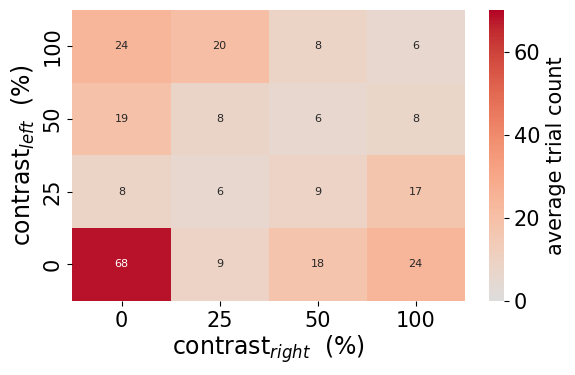

In [7]:
# @title Counts averaging
#sum counts per stimComb by session
sum_total_count=np.zeros((len(unique_stim_r),len(unique_stim_l)))
for ses in range(len(ses_total_count)):
  temp0 = np.where(ses_total_count[ses]==np.max(ses_total_count[ses]))[0].tolist()
  temp1 = np.where(ses_total_count[ses]==np.max(ses_total_count[ses]))[1].tolist()
  sum_total_count += ses_total_count[ses]
#average by mouse
avg_total_count = sum_total_count / len(ses_total_count)
#plot heatmap
avg_total_count_pd = pd.DataFrame(avg_total_count)
plt.figure()
sns.heatmap(avg_total_count_pd, annot=True, annot_kws={"size": 8}, fmt='.0f', cmap="coolwarm", \
  center=0, xticklabels=[0,25,50,100], yticklabels=[100,50,25,0], vmin=0, vmax=70,\
  cbar_kws={'label': 'average trial count'})
plt.xlabel('contrast$_{right}$  (%)', fontsize=17, labelpad=2)
plt.ylabel('contrast$_{left}$  (%)', fontsize=17, labelpad=4)

#thus, for most sessions, the maximum trial count falls in stimComb(0,0)

## Result: Psychometric

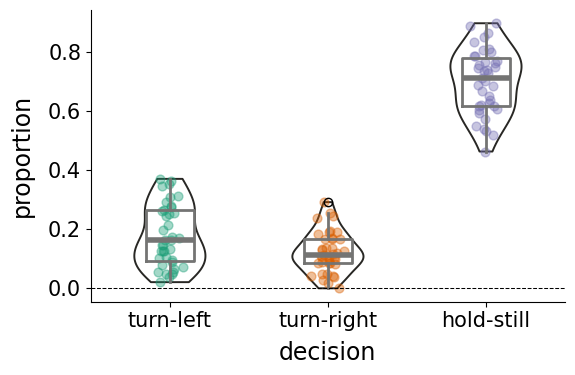

In [8]:
# @title Decision probabilities: with stimComb(0,0), indipendent of prior
#newDict['resp']: which side the response was (-1, 0, 1). 
#                 When the right-side stimulus had higher contrast, the correct choice was -1. 
#                 0 is a no go response.
from matplotlib.lines import lineStyles


p_turn_left=list()
p_turn_right=list()
p_hold_still=list()
for ses in range(len(newDict['name'])): # per session
  comb_index=list()
  temp_comb_00 = newDict['comb_index'][ses][index_comb_00[0]]
  temp_resp = []
  for idx in range(len(temp_comb_00)): # per trials
    temp_resp += [newDict['resp'][ses][temp_comb_00[idx]]]
  len_turn_left = len(np.where(np.array(temp_resp)==-1)[0])
  p_turn_left.append(len_turn_left/len(temp_resp))
  len_turn_right = len(np.where(np.array(temp_resp)==1)[0])
  p_turn_right.append(len_turn_right/len(temp_resp))
  len_hold_still = len(np.where(np.array(temp_resp)==0)[0])
  p_hold_still.append(len_hold_still/len(temp_resp))


#static parameters
POSITIONS = [0,1,2]
GREY_DARK = '#747473'
BLACK = '#282724'
COLOR_SCALE = ['#1B9E77','#D95F02','#7570B3']
medianprops = dict(linewidth=4, color=GREY_DARK, solid_capstyle='butt')
boxprops = dict(linewidth=2, color=GREY_DARK)
decision = ['turn-left', 'turn-right', 'hold-still']
xlabels = [f"{dec}" for i, dec in enumerate(decision)]

#data for ploting
jitter=0.04
x_data = [np.ones(len(newDict['name']))*0, np.ones(len(newDict['name']))*1, np.ones(len(newDict['name']))*2]
x_jittered = [x + st.t(df=8, scale=jitter).rvs(len(x)) for x in x_data]
y_data = [p_turn_left,p_turn_right,p_hold_still]

#plots
fig, ax = plt.subplots()
#violins
violins = ax.violinplot(y_data, positions=POSITIONS, widths=0.45, showextrema=False)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
#supervised boxes
ax.boxplot(y_data, positions=POSITIONS, showfliers=True, showcaps=False,\
            medianprops=medianprops, whiskerprops=boxprops, boxprops=boxprops)
#supervised scatters
for x, y, color in zip([x_jittered[0],x_jittered[1],x_jittered[2]], [p_turn_left,p_turn_right,p_hold_still], COLOR_SCALE):
    ax.scatter(x, y, s=40, color=color, alpha=0.4)

ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, ha='center', ma='center')
ax.set_xlabel('decision', fontsize=17, labelpad=7)
ax.set_ylabel('proportion', fontsize=17, labelpad=10)
#ax.set_ylabel('probability', fontsize=17, labelpad=10)
temp_xlim = plt.xlim()
ax.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line


In [9]:
# @title Dict supplement: previous indexes of stimComb(0,0)
temp_comb_index = []
newDict.update({'comb00_p1_idx':temp_comb_index})
for ses in range(len(newDict['name'])):
  comb_index = list()
  temp_comb_00 = newDict['comb_index'][ses][index_comb_00[0]]
  temp_comb_00p1 = temp_comb_00 - 1 
  # ↑ this is the prior trial list of stimComb(0,0) trials from the 1st session
  # no worry abt '-1' index, because it won't be found in the original list
  
  for comb in range(len(newDict['comb_index'][ses])): # search the index in 16 stimCombs
    a = []
    for idx in range(len(temp_comb_00p1)):
      temp = newDict['comb_index'][ses][comb]==temp_comb_00p1[idx]
      #highlight the identical indexes, but pale the others
      if sum(temp):
        a += [1]
      else:
        a += [0]
    temp_comb = (temp_comb_00p1 + 1) * a
    # ↑ +1 so that index '0' (if any) won't be wiped out
    temp_comb = temp_comb[temp_comb>0] - 1
    # ↑ then -1 to correct
    comb_index.append(temp_comb) #trials belonging to specific stimComb

  temp_comb_index = newDict['comb00_p1_idx']
  temp_comb_index.append(comb_index)
  newDict['comb00_p1_idx'] = temp_comb_index # key-value: session-#comb00_prior_trial_per_stimComb


In [10]:
# @title Result: proportion differences for stimulus-specific priors
avg_p_lhp_L = list()
avg_p_lhp_R = list()
avg_p_rhp_L = list()
avg_p_rhp_R = list()
diff_pLR = list()
diff_pRL = list()
for ses in range(len(newDict['comb00_p1_idx'])):
    pCho_L = 0
    pCho_R = 0
    for i in range(len(index_comb_Lr)):
        temp = newDict['comb00_p1_idx'][ses][index_comb_Lr[i]]
        temp_resp = []
        for idx in range(len(temp)):
            #temp_resp += [newDict['resp'][ses][temp[idx]]] # is this what you want ? this is the resp in prev trial !
            temp_resp += [newDict['resp'][ses][temp[idx]+1]] # +1 then that should be correct

        if len(temp)==0:
            pCho_L += 0
            pCho_R += 0
        else:
            pCho_L += np.sum(temp_resp==np.ones(len(temp_resp)))/len(temp)
            pCho_R += np.sum(temp_resp==np.ones(len(temp_resp))*-1)/len(temp)
    avg_p_lhp_L.append(pCho_L/len(index_comb_Lr))
    avg_p_lhp_R.append(pCho_R/len(index_comb_Lr))
    diff_pLR.append(avg_p_lhp_L[-1] - avg_p_lhp_R[-1])

    pCho_L = 0
    pCho_R = 0
    #print("choice probabilities, after rhp")
    for i in range(len(index_comb_lR)):
        temp = newDict['comb00_p1_idx'][ses][index_comb_lR[i]]
        temp_resp = []
        for idx in range(len(temp)):
            #temp_resp += [newDict['resp'][ses][temp[idx]]]
            temp_resp += [newDict['resp'][ses][temp[idx]+1]] # +1 then that should be correct

        if len(temp)==0:
            pCho_L += 0
            pCho_R += 0
        else:
            #NOTE: for correct resp, 
            # 1 means left-higher comb and turning right, 
            # -1 means right-higher comb and turning left.
            pCho_L += np.sum(temp_resp==np.ones(len(temp_resp)))/len(temp)
            pCho_R += np.sum(temp_resp==np.ones(len(temp_resp))*-1)/len(temp)
    avg_p_rhp_L.append(pCho_L/len(index_comb_lR))
    avg_p_rhp_R.append(pCho_R/len(index_comb_lR))
    diff_pRL.append(avg_p_rhp_R[-1] - avg_p_rhp_L[-1])


In [11]:
tstatrel_lhp, prel_value_lhp = stats.ttest_rel(avg_p_lhp_L, avg_p_lhp_R)  
tstatrel_rhp, prel_value_rhp = stats.ttest_rel(avg_p_rhp_L, avg_p_rhp_R)  
print('t-statistic: lhp, %.1f; rhp, %.1f'%(tstatrel_lhp,tstatrel_rhp))
print('p-value: lhp, %.3f; rhp, %.3f'%(prel_value_lhp,prel_value_rhp))
cirel_lhp = stats.ttest_rel(avg_p_lhp_L, avg_p_lhp_R).confidence_interval()
cirel_rhp = stats.ttest_rel(avg_p_rhp_L, avg_p_rhp_R).confidence_interval()
print('CI: lhp, [%.2f, %.2f]; rhp, [%.2f, %.2f]'\
      %(cirel_lhp[0],cirel_lhp[-1],cirel_rhp[0],cirel_rhp[-1]))
print('df: lhp, %i; rhp, %i'%(len(avg_p_lhp_L)-1,len(avg_p_rhp_L)-1))

t-statistic: lhp, -1.9; rhp, -0.7
p-value: lhp, 0.066; rhp, 0.484
CI: lhp, [-0.12, 0.00]; rhp, [-0.10, 0.05]
df: lhp, 38; rhp, 38


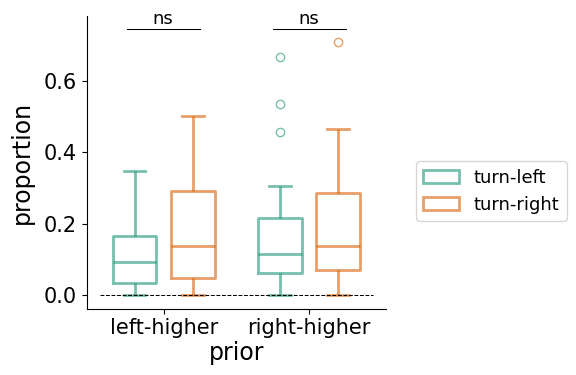

In [12]:
# @title Result: proportions of each turning decisions in each biasing prior
#NOTE: for each resp, 
# 1 means turning right, reporting a left-higher comb;  
# -1 means turning left, reporting a right-higher comb;
act_left = ['turn-left' for i in avg_p_lhp_L]
act_right = ['turn-right' for i in avg_p_lhp_R]
act = act_left + act_right
act += act

avg_p_lhp = avg_p_lhp_L + avg_p_lhp_R
avg_p_rhp = avg_p_rhp_L + avg_p_rhp_R
avg_p_xhp = avg_p_lhp + avg_p_rhp
prior_lhp = ['left-higher' for i in avg_p_lhp]
prior_rhp = ['right-higher' for i in avg_p_rhp]
PRIOR = prior_lhp + prior_rhp

avg_p_dict = {'proportion':avg_p_xhp, 'prior':PRIOR, 'resp':act}
#avg_p_dict = {'probability':avg_p_xhp, 'prior':PRIOR, 'resp':act}
avg_p_dict_pd = pd.DataFrame(data=avg_p_dict)

temp_COLOR_SCALE = [(0.1067,0.5882,0.4667,0.600), (0.8491,0.3734,0.0078,0.600)]


boxplot = sns.boxplot(data=avg_p_dict_pd, y='proportion', x='prior', hue='resp', \
#boxplot = sns.boxplot(data=avg_p_dict_pd, y='probability', x='prior', hue='resp', \
    palette=temp_COLOR_SCALE, fill=False, gap=.25, color='white', linewidth=2)
x = boxplot.get_xticks()
y = boxplot.get_ylim()
plt.plot([min(x)-0.25, min(x)+0.25],[max(y), max(y)], 'k', linewidth=0.75)
plt.plot([max(x)-0.25, max(x)+0.25],[max(y), max(y)], 'k', linewidth=0.75)
plt.legend(loc=(1.1,0.3), fontsize=13)
plt.text(min(x)-0.075, max(y)+0.015, 'ns', fontsize=13)
plt.text(max(x)-0.075, max(y)+0.015, 'ns', fontsize=13)
plt.xlabel('prior', fontsize=17, labelpad=2)
plt.ylabel('proportion', fontsize=17, labelpad=7)
#plt.ylabel('probability', fontsize=17, labelpad=7)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), \
        'k', linestyle='--', linewidth=0.75) # add a reference line

In [13]:
# @title Result: proportion differences for stimulus-specific priors
temp_len = [list(), list()] # 2 lists are enough, for left-higher & right-higher
count_L_lhp = list()
count_R_lhp = list()
count_L_rhp = list()
count_R_rhp = list()
for ses in range(len(newDict['comb00_p1_idx'])): # 39 sessions
    tempsum_len = [0, 0]
    count_L = 0
    count_R = 0
    for i in range(len(index_comb_Lr)): # 6 combs
        temp = newDict['comb00_p1_idx'][ses][index_comb_Lr[i]]
        tempsum_len[0] += len(temp)
        
        temp_resp = []
        for idx in range(len(temp)):
            temp_resp += [newDict['resp'][ses][temp[idx]+1]] # +1 then that should be correct

        if len(temp)==0:
            count_L += 0
            count_R += 0
        else:
            count_L += np.sum(temp_resp==np.ones(len(temp_resp)))
            count_R += np.sum(temp_resp==np.ones(len(temp_resp))*-1)
    count_L_lhp.append(count_L)
    count_R_lhp.append(count_R)
    temp_len[0].append(tempsum_len[0])

    count_L = 0
    count_R = 0
    for i in range(len(index_comb_lR)): # 6 combs
        temp = newDict['comb00_p1_idx'][ses][index_comb_lR[i]]
        tempsum_len[-1] += len(temp)

        temp_resp = []
        for idx in range(len(temp)): # trials
            temp_resp += [newDict['resp'][ses][temp[idx]+1]] # +1 then that should be correct

        if len(temp)==0:
            count_L += 0
            count_R += 0
        else:
            #NOTE: for correct resp, 
            # 1 means left-higher comb and turning right, 
            # -1 means right-higher comb and turning left.
            count_L += np.sum(temp_resp==np.ones(len(temp_resp)))
            count_R += np.sum(temp_resp==np.ones(len(temp_resp))*-1)
    count_L_rhp.append(count_L)
    count_R_rhp.append(count_R)
    temp_len[-1].append(tempsum_len[-1])


Text(0, 0.5, '$\\Delta$P$_{lhp}$')

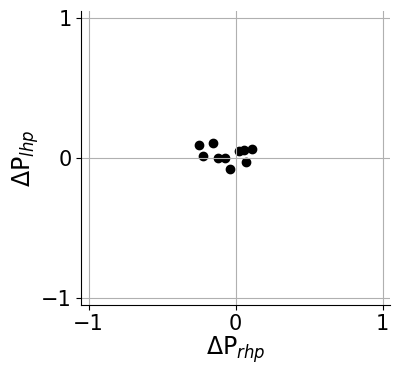

In [14]:
mou_len_L = list()
mou_count_L_lhp = list()
mou_count_L_rhp = list()
mou_len_R = list()
mou_count_R_lhp = list()
mou_count_R_rhp = list()
for mou in range(len(unique_name)): # per mouse
    mou_len_L.append(list())
    mou_len_R.append(list())
    mou_count_L_lhp.append(list())
    mou_count_L_rhp.append(list())
    mou_count_R_lhp.append(list())
    mou_count_R_rhp.append(list())
    for ses in range(len(newDict['name'])): # per session
        if newDict['name'][ses]==unique_name[mou]:
            mou_count_L_lhp[mou].append(count_L_lhp[ses])
            mou_count_L_rhp[mou].append(count_L_rhp[ses])
            mou_len_L[mou].append(temp_len[0][ses])
            mou_len_R[mou].append(temp_len[-1][ses])
            mou_count_R_lhp[mou].append(count_R_lhp[ses])
            mou_count_R_rhp[mou].append(count_R_rhp[ses])

moupool_len_L = list()
moupool_len_R = list()
moupool_count_L_lhp = list()
moupool_count_L_rhp = list()
moupool_count_R_lhp = list()
moupool_count_R_rhp = list()
for mou in range(len(unique_name)): # per mouse
    moupool_len_L.append(sum(mou_len_L[mou]))
    moupool_len_R.append(sum(mou_len_R[mou]))
    moupool_count_L_lhp.append(sum(mou_count_L_lhp[mou]))
    moupool_count_L_rhp.append(sum(mou_count_L_rhp[mou]))
    moupool_count_R_lhp.append(sum(mou_count_R_lhp[mou]))
    moupool_count_R_rhp.append(sum(mou_count_R_rhp[mou]))

dec_pp_L_lhp_mou = np.array(moupool_count_L_lhp)/np.array(moupool_len_L)
dec_pp_L_rhp_mou = np.array(moupool_count_L_rhp)/np.array(moupool_len_L)
diff1 = dec_pp_L_lhp_mou - dec_pp_L_rhp_mou
dec_pp_R_lhp_mou = np.array(moupool_count_R_lhp)/np.array(moupool_len_R)
dec_pp_R_rhp_mou = np.array(moupool_count_R_rhp)/np.array(moupool_len_R)
diff2 = dec_pp_R_rhp_mou - dec_pp_R_lhp_mou


#Figure
plt.figure(figsize=(4.25,4))
plt.scatter(diff1, diff2, color='k')
plt.ylim([-1.05,1.05])
plt.xlim([-1.05,1.05])
plt.xticks(np.arange(3)-1)
plt.yticks(np.arange(3)-1)
plt.grid(True)
plt.xlabel('$\Delta$P$_{rhp}$', fontsize=17, labelpad=0)
plt.ylabel('$\Delta$P$_{lhp}$', fontsize=17, labelpad=0)

In [15]:
# @title Result: proportion differences for decision-specific priors

# @title Dict supplement: previous indexes of stimComb(0,0)
temp_dec_index = []
newDict.update({'comb00_p1_dec_idx':temp_dec_index})
for ses in range(len(newDict['name'])):
  dec_index = list()
  temp_comb_00 = newDict['comb_index'][ses][index_comb_00[0]]
  temp_comb_00p1 = temp_comb_00 - 1 
  # ↑ this is the prior trial list of stimComb(0,0) trials from the 1st session
  temp_comb_00p1 = temp_comb_00p1[temp_comb_00p1>0] # make sure no '-1' index ...
  
  for dec in range(len(np.unique(newDict['resp'][ses]))): # search the index in 3 decisions 
    # [dec=0] resp=-1, turn left, right-higher/random-move
    # [dec=1] resp=0, hold still, no stim
    # [dec=2] resp=1, turn right, left-higher/random-move
    temp = np.unique(newDict['resp'][ses])[dec]==newDict['resp'][ses][temp_comb_00p1]
    temp_dec = (temp_comb_00p1 + 1) * temp
    # ↑ +1 so that index '0' (if any) won't be wiped out
    temp_dec = temp_dec[temp_dec>0] - 1
    # ↑ then -1 to correct
    dec_index.append(temp_dec) #trials belonging to specific stimComb

  temp_dec_index = newDict['comb00_p1_dec_idx']
  temp_dec_index.append(dec_index)
  newDict['comb00_p1_dec_idx'] = temp_dec_index # key-value: session-#comb00_prior_trial_per_stimComb


decavg_p_L = [list(), list(), list()]
decavg_p_R = [list(), list(), list()]
decdiff_pLR = [list(), list(), list()]
for ses in range(len(newDict['comb00_p1_dec_idx'])):
    pCho_L = 0
    pCho_R = 0
    for dec in range(len(np.unique(newDict['resp'][ses]))):
        if np.unique(newDict['resp'][ses])[dec]!=0:
            #if np.unique(newDict['resp'][ses])[dec]==-1, mouse experienced left-turn prior;
            #if np.unique(newDict['resp'][ses])[dec]==1, mouse experienced right-turn prior.
            temp = newDict['comb00_p1_dec_idx'][ses][dec]
            temp_resp = []
            for idx in range(len(temp)):
                temp_resp += [newDict['resp'][ses][temp[idx]+1]] # +1 then that should be correct

            if len(temp)==0:
                decavg_p_L[dec].append([0])
                decavg_p_R[dec].append([0])
            else:
                decavg_p_L[dec].append(np.sum(temp_resp==np.ones(len(temp_resp)))/len(temp_resp))
                decavg_p_R[dec].append(np.sum(temp_resp==np.ones(len(temp_resp))*-1)/len(temp_resp))
            decdiff_pLR[dec].append(decavg_p_L[dec][-1] - decavg_p_R[dec][-1])


# 'decdiff_pLR[0] > 0' indicates the 'turn_left' decision in previous trial attracted mouse's current decision
# ie the mouse prefers making a 'turn_left' decision after making a 'turn_left' decision

# similarly, 'decdiff_pLR[-1] < 0' also indicates an attraction from the previous trial
# but after making a 'turn_right' decison

# data points centering around the origin suggests there's no aggregate biasing effect

In [16]:
tstatrel_lhp, prel_value_lhp = stats.ttest_rel(decavg_p_L[0],decavg_p_R[0])
tstatrel_rhp, prel_value_rhp = stats.ttest_rel(decavg_p_L[-1],decavg_p_R[-1])
print('t-statistic: lhp, %.1f; rhp, %.1f'%(tstatrel_lhp,tstatrel_rhp))
print('p-value: lhp, %.3f; rhp, %.3f'%(prel_value_lhp,prel_value_rhp))
cirel_lhp = stats.ttest_rel(decavg_p_L[0], decavg_p_R[0]).confidence_interval()
cirel_rhp = stats.ttest_rel(decavg_p_L[-1], decavg_p_R[-1]).confidence_interval()
print('CI: lhp, [%.2f, %.2f]; rhp, [%.2f, %.2f]'\
      %(cirel_lhp[0],cirel_lhp[-1],cirel_rhp[0],cirel_rhp[-1]))
print('df: lhp, %i; rhp, %i'%(len(decavg_p_L[0])-1,len(decavg_p_L[-1])-1))

t-statistic: lhp, -0.5; rhp, -2.6
p-value: lhp, 0.655; rhp, 0.013
CI: lhp, [-0.08, 0.05]; rhp, [-0.14, -0.02]
df: lhp, 38; rhp, 38


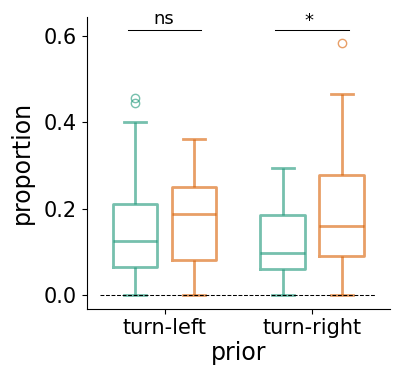

In [17]:
# @title Result: proportions of each turning decisions in each TURNED prior
#NOTE: for each resp, 
# 1 means turning right, reporting a left-higher comb;  
# -1 means turning left, reporting a right-higher comb;

avg_p_tl = decavg_p_L[0] + decavg_p_R[0]
avg_p_tr = decavg_p_L[-1] + decavg_p_R[-1]
avg_p_tx = avg_p_tl + avg_p_tr
prior_tl = ['turn-left' for i in avg_p_tl]
prior_tr = ['turn-right' for i in avg_p_tr]
PRIOR = prior_tl + prior_tr

avg_p_t_dict = {'proportion':avg_p_tx, 'prior':PRIOR, 'resp':act}
#avg_p_t_dict = {'probability':avg_p_tx, 'prior':PRIOR, 'resp':act}
avg_p_t_dict_pd = pd.DataFrame(data=avg_p_t_dict)

plt.figure(figsize=(4.25,4))
boxplot_t = sns.boxplot(data=avg_p_t_dict_pd, y='proportion', x='prior', hue='resp', \
#boxplot_t = sns.boxplot(data=avg_p_t_dict_pd, y='probability', x='prior', hue='resp', \
    palette=temp_COLOR_SCALE, fill=False, gap=.25, color='white', linewidth=2,legend=False)
x = boxplot_t.get_xticks()
y = boxplot_t.get_ylim()
plt.plot([min(x)-0.25, min(x)+0.25],[max(y), max(y)], 'k', linewidth=0.75)
plt.plot([max(x)-0.25, max(x)+0.25],[max(y), max(y)], 'k', linewidth=0.75)
#plt.legend(loc=(1.1,0.3), fontsize=13)
plt.text(min(x)-0.075, max(y)+0.015, 'ns', fontsize=13)
plt.text(max(x)-0.05, max(y)+0.01, '*', fontsize=13)
plt.xlabel('prior', fontsize=17, labelpad=2)
plt.ylabel('proportion', fontsize=17, labelpad=7)
#plt.ylabel('probability', fontsize=17, labelpad=7)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), \
        'k', linestyle='--', linewidth=0.75) # add a reference line

Text(0, 0.5, '$\\Delta$P$_{trp}$')

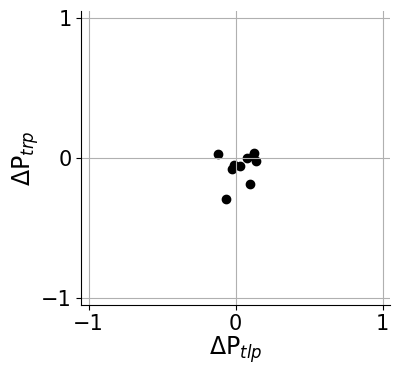

In [18]:
# **Pool same mouse's data together !**

# Result: proportion differences for decision-specific priors

temp_len = [list(), list(), list()]
temp_decavg_p_L = [list(), list(), list()]
temp_decavg_p_R = [list(), list(), list()]
for ses in range(len(newDict['comb00_p1_dec_idx'])):
    pCho_L = 0
    pCho_R = 0
    for dec in range(len(np.unique(newDict['resp'][ses]))): # [-1, 0, 1]
        if np.unique(newDict['resp'][ses])[dec]!=0:
            #if np.unique(newDict['resp'][ses])[dec]==-1, mouse experienced left-turn prior;
            #if np.unique(newDict['resp'][ses])[dec]==1, mouse experienced right-turn prior.
            temp_idx_list = newDict['comb00_p1_dec_idx'][ses][dec]
            temp_len[dec].append(len(temp_idx_list))
            temp_resp = []
            for idx in range(len(temp_idx_list)):
                temp_resp += [newDict['resp'][ses][temp_idx_list[idx]+1]] # +1 then that should be correct

            if len(temp_idx_list)==0:
                temp_decavg_p_L[dec].append([0])
                temp_decavg_p_R[dec].append([0])
            else:
                temp_decavg_p_L[dec].append(np.sum(temp_resp==np.ones(len(temp_resp))))
                temp_decavg_p_R[dec].append(np.sum(temp_resp==np.ones(len(temp_resp))*-1))


temptemp_len_L = [list(), list(), list(), list(), list(),\
                    list(), list(), list(), list(), list()]
temp_mou_dec_p_L_lhp = [list(), list(), list(), list(), list(),\
                    list(), list(), list(), list(), list()]
temp_mou_dec_p_L_rhp = [list(), list(), list(), list(), list(),\
                    list(), list(), list(), list(), list()]
temptemp_len_R = [list(), list(), list(), list(), list(),\
                    list(), list(), list(), list(), list()]
temp_mou_dec_p_R_lhp = [list(), list(), list(), list(), list(),\
                    list(), list(), list(), list(), list()]
temp_mou_dec_p_R_rhp = [list(), list(), list(), list(), list(),\
                    list(), list(), list(), list(), list()]
for mou in range(len(unique_name)):
    for ses in range(len(newDict['name'])):
        if newDict['name'][ses]==unique_name[mou]:
            temp_mou_dec_p_L_lhp[mou].append(temp_decavg_p_L[0][ses])
            temp_mou_dec_p_L_rhp[mou].append(temp_decavg_p_L[-1][ses])
            temptemp_len_L[mou].append(temp_len[0][ses])
            temptemp_len_R[mou].append(temp_len[-1][ses])
            temp_mou_dec_p_R_lhp[mou].append(temp_decavg_p_R[0][ses])
            temp_mou_dec_p_R_rhp[mou].append(temp_decavg_p_R[-1][ses])

len_mou_L = list()
dec_p_L_lhp_mou = list()
dec_p_L_rhp_mou = list()
len_mou_R = list()
dec_p_R_lhp_mou = list()
dec_p_R_rhp_mou = list()
for mou in range(len(unique_name)):
    len_mou_L.append(sum(temptemp_len_L[mou]))
    dec_p_L_lhp_mou.append(sum(temp_mou_dec_p_L_lhp[mou]))
    dec_p_L_rhp_mou.append(sum(temp_mou_dec_p_L_rhp[mou]))
    len_mou_R.append(sum(temptemp_len_R[mou]))
    dec_p_R_lhp_mou.append(sum(temp_mou_dec_p_R_lhp[mou]))
    dec_p_R_rhp_mou.append(sum(temp_mou_dec_p_R_rhp[mou]))

dec_pp_L_lhp_mou = np.array(dec_p_L_lhp_mou)/np.array(len_mou_L)
dec_pp_L_rhp_mou = np.array(dec_p_L_rhp_mou)/np.array(len_mou_L)
diff1 = dec_pp_L_lhp_mou - dec_pp_L_rhp_mou
dec_pp_R_lhp_mou = np.array(dec_p_R_lhp_mou)/np.array(len_mou_R)
dec_pp_R_rhp_mou = np.array(dec_p_R_rhp_mou)/np.array(len_mou_R)
diff2 = dec_pp_R_rhp_mou - dec_pp_R_lhp_mou


#Figure
plt.figure(figsize=(4.25,4))
plt.scatter(diff1, diff2, color='k')
plt.ylim([-1.05,1.05])
plt.xlim([-1.05,1.05])
plt.xticks(np.arange(3)-1)
plt.yticks(np.arange(3)-1)
plt.grid(True)
plt.xlabel('$\Delta$P$_{tlp}$', fontsize=17, labelpad=0)
plt.ylabel('$\Delta$P$_{trp}$', fontsize=17, labelpad=0)


## Result: Modeling

### model inputs

In [19]:
mou_currC_L = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_currC_R = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_prevC_L = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_prevC_R = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_currD = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_prevD = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_prevRw = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
for mou in range(len(unique_name)):
    for ses in range(len(newDict['name'])):
        if newDict['name'][ses]==unique_name[mou]:
            mou_currC_L[mou] = np.vstack((mou_currC_L[mou],newDict['stim_l'][ses][1:].reshape(len(newDict['stim_l'][ses][1:]),1)))
            mou_currC_R[mou] = np.vstack((mou_currC_R[mou],newDict['stim_r'][ses][1:].reshape(len(newDict['stim_r'][ses][1:]),1)))
            mou_prevC_L[mou] = np.vstack((mou_prevC_L[mou],newDict['stim_l'][ses][:-1].reshape(len(newDict['stim_l'][ses][:-1]),1)))
            mou_prevC_R[mou] = np.vstack((mou_prevC_R[mou],newDict['stim_r'][ses][:-1].reshape(len(newDict['stim_r'][ses][:-1]),1)))
            mou_currD[mou] = np.vstack((mou_currD[mou],newDict['resp'][ses][1:].reshape(len(newDict['resp'][ses][1:]),1)))
            mou_prevD[mou] = np.vstack((mou_prevD[mou],newDict['resp'][ses][:-1].reshape(len(newDict['resp'][ses][:-1]),1)))
            mou_prevRw[mou] = np.vstack((mou_prevRw[mou],newDict['reward'][ses][:-1].reshape(len(newDict['reward'][ses][:-1]),1)))
    for trial in np.where(mou_prevRw[mou]==-1)[0]:
        mou_prevRw[mou][trial] = 0


### Tensorflow

In [20]:
# for ref
unique_dec = np.unique(mou_currD[mou]) # dec==-1, left-turn; dec==1, right-turn.
print('unique decision:\n',unique_dec)
one_hot_dec = tf.keras.utils.to_categorical(np.unique(mou_currD[mou]), num_classes=len(unique_dec))
print('\ncorresponding decision in one-hot encoding:\n',one_hot_dec,'\n')
print('corresponding index:')
for i in range(len(unique_dec)):
    print(np.where(one_hot_dec[i])[0])

unique decision:
 [-1.  0.  1.]

corresponding decision in one-hot encoding:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]] 

corresponding index:
[2]
[0]
[1]


##### Primary model

In [21]:
pred_reg_prevD = list()
class_pred_reg_prevD = list()
mou_weights_reg_prevD = list()
mou_accuracy_reg_prevD = list()
aic_primary = []
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevC_L[mou],mou_prevC_R[mou],mou_prevD[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    mou_accuracy_reg_prevD.append(history.history['accuracy'][-1]) # Retrieve the accuracy values from the history and pick the latest one
    pred_reg_prevD.append(model.predict(X)) # Make predictions
    class_pred_reg_prevD.append(np.argmax(pred_reg_prevD[-1], axis=1)) # Convert softmax output to class predictions

    # calc AIC for model comparison
    likelihood = -history.history['loss'][-1]
    num_parameters = np.sum([np.prod(variable.shape) for variable in model.trainable_variables])
    aic_primary.append(-2 * likelihood + num_parameters * 2)
    print(f'AIC: {aic_primary[-1]}')

    # Access and print the weights of each layer
    for layer in model.layers:
        mou_weights_reg_prevD.append(layer.get_weights())
        for i, weights in enumerate(layer.get_weights()):
            print(f"Weights {i + 1} shape:", weights.shape)
            print(weights)


**  Cori :




22/22 [==============================] - 0s 693us/step
AIC: 37.67654478549957
Weights 1 shape: (5, 3)
[[-1.5915238   2.2566845  -1.3545539 ]
 [-1.1659144  -1.7447722   1.3184991 ]
 [-0.64917284 -0.97660893  0.24697828]
 [ 0.6599461   0.82505274 -0.9440848 ]
 [ 0.43187255  0.6531589  -0.20232701]]
Weights 2 shape: (3,)
[ 0.62605053 -0.5956083  -0.18151511]

**  Forssmann :
33/33 [==============================] - 0s 857us/step
AIC: 37.601836800575256
Weights 1 shape: (5, 3)
[[-1.6004862   1.5477862  -2.0344944 ]
 [-1.5823892  -2.2997446   2.057135  ]
 [ 0.5601693  -0.02496789  0.05515906]
 [-0.43498525  0.21563114  0.01481237]
 [ 0.11861612  0.3711983   0.22318915]]
Weights 2 shape: (3,)
[ 0.87001455 -0.5737922  -0.16038498]

**  Hench :
44/44 [==============================] - 0s 639us/step
AIC: 37.582096099853516
Weights 1 shape: (5, 3)
[[-1.6933259   1.367587   -3.0416024 ]
 [-1.287166   -1.9575701   1.8092895 ]
 [ 0.0366688  -1.1456048   1.1200984 ]
 [-0.02671093  0.

In [22]:
# @title Ordering estimations
moutf_res_L_params_pri = np.array([])
moutf_res_H_params_pri = np.array([])
moutf_res_R_params_pri = np.array([])
for mou in range(len(unique_name)):
    temp_L_params=list()
    temp_L_params.append(mou_weights_reg_prevD[mou][1][2]) 
    # '[1]' marks the internal-bias weights, '[2]' marks the left-turn dec
    temp_H_params=list()
    temp_H_params.append(mou_weights_reg_prevD[mou][1][0]) 
    # '[1]' marks the internal-bias weights, '[0]' marks the hold-still dec
    temp_R_params=list()
    temp_R_params.append(mou_weights_reg_prevD[mou][1][1]) 
    # 1st '[1]' marks the internal-bias weights, 2nd '[1]' marks the right-turn dec
    for param in range(input_num):
        temp_L_params.append(mou_weights_reg_prevD[mou][0][param][2]) 
        # '[0]' marks the experiment-related weights, '[2]' marks the left-turn dec
        temp_H_params.append(mou_weights_reg_prevD[mou][0][param][0]) 
        # 1st '[0]' marks the experiment-related weights, 2nd '[0]' marks the hold-still dec
        temp_R_params.append(mou_weights_reg_prevD[mou][0][param][1]) 
        # '[0]' marks the experiment-related weights, '[1]' marks the right-turn dec
    temptemp_L_params = np.array(temp_L_params).reshape(1,len(temp_L_params))
    temptemp_H_params = np.array(temp_H_params).reshape(1,len(temp_H_params))
    temptemp_R_params = np.array(temp_R_params).reshape(1,len(temp_R_params))
    if mou:
        moutf_res_L_params_pri = np.vstack((moutf_res_L_params_pri, temptemp_L_params))
        moutf_res_H_params_pri = np.vstack((moutf_res_H_params_pri, temptemp_H_params))
        moutf_res_R_params_pri = np.vstack((moutf_res_R_params_pri, temptemp_R_params))
    else:
        moutf_res_L_params_pri = temptemp_L_params
        moutf_res_H_params_pri = temptemp_H_params
        moutf_res_R_params_pri = temptemp_R_params


In [23]:
# @title Statistics
tstat_tf_L_pri = [list(), list(), list(), list(), list(), list()]
p_value_tf_L_pri = [list(), list(), list(), list(), list(), list()]
tstat_tf_H_pri = [list(), list(), list(), list(), list(), list()]
p_value_tf_H_pri = [list(), list(), list(), list(), list(), list()]
tstat_tf_R_pri = [list(), list(), list(), list(), list(), list()]
p_value_tf_R_pri = [list(), list(), list(), list(), list(), list()]
feature_names=['internal-bias','currStim_L','currStim_R','prevStim_L','prevStim_R', 'prevDec']
for param in range(np.size(moutf_res_L_params_pri, axis=1)):
    # the last parameter from Theiler is an outlier, thus is removed below
    tstat_tf_L_pri[param], p_value_tf_L_pri[param] = stats.ttest_1samp(moutf_res_L_params_pri[:,param], popmean=0)
    tstat_tf_H_pri[param], p_value_tf_H_pri[param] = stats.ttest_1samp(moutf_res_H_params_pri[:,param], popmean=0)
    tstat_tf_R_pri[param], p_value_tf_R_pri[param] = stats.ttest_1samp(moutf_res_R_params_pri[:,param], popmean=0)
    print('\nparam: ', feature_names[param])
    print('t-statistic: turn-left, %.1f; hold-still, %.1f; turn-right, %.1f'
          %(tstat_tf_L_pri[param],tstat_tf_H_pri[param],tstat_tf_R_pri[param]))
    print('p-value: turn-left, %.3f; hold-still, %.3f; turn-right, %.3f'
          %(p_value_tf_L_pri[param],p_value_tf_H_pri[param],p_value_tf_R_pri[param]))


param:  internal-bias
t-statistic: turn-left, -3.6; hold-still, 11.8; turn-right, -5.7
p-value: turn-left, 0.005; hold-still, 0.000; turn-right, 0.000

param:  currStim_L
t-statistic: turn-left, -11.6; hold-still, -8.8; turn-right, 15.8
p-value: turn-left, 0.000; hold-still, 0.000; turn-right, 0.000

param:  currStim_R
t-statistic: turn-left, 14.3; hold-still, -6.9; turn-right, -11.1
p-value: turn-left, 0.000; hold-still, 0.000; turn-right, 0.000

param:  prevStim_L
t-statistic: turn-left, 5.4; hold-still, 2.6; turn-right, -4.3
p-value: turn-left, 0.000; hold-still, 0.027; turn-right, 0.002

param:  prevStim_R
t-statistic: turn-left, -3.3; hold-still, -0.2; turn-right, 7.0
p-value: turn-left, 0.010; hold-still, 0.863; turn-right, 0.000

param:  prevDec
t-statistic: turn-left, -1.5; hold-still, 0.5; turn-right, 3.2
p-value: turn-left, 0.163; hold-still, 0.601; turn-right, 0.012


(-3.3917859554290772, 3.5185161781311036)

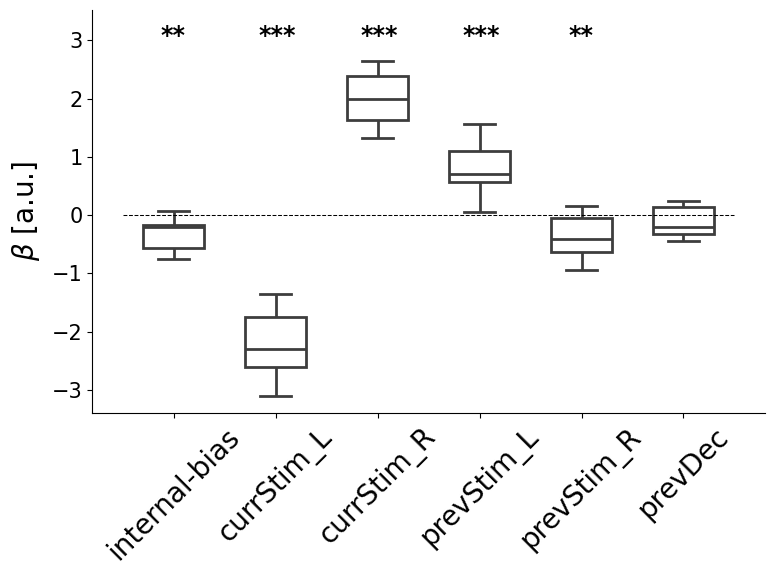

In [24]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(data=moutf_res_L_params_pri, showfliers=False, gap=.25, color='white', linewidth=2)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line
#plt.title('TF: Turn-left _ per Mouse', fontweight='bold')

plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize=20)
plt.ylabel(r'$\beta$ [a.u.]', fontsize=20, labelpad=7)

x = boxplot.get_xticks()
y = boxplot.get_ylim()
for i in x:
    if p_value_tf_L_pri[i]<0.001:
        plt.text(i-0.17, max(y)+0.015, '***', fontsize=17, fontweight='bold')
    elif p_value_tf_L_pri[i]<0.01:
        plt.text(i-0.13, max(y)+0.015, '**', fontsize=17, fontweight='bold')
    elif p_value_tf_L_pri[i]<0.05:
        plt.text(i-0.09, max(y)+0.015, '*', fontsize=17, fontweight='bold')

plt.ylim([y[0], y[1]+y[1]*0.2])

(-2.4650672316551208, 1.2752896356582641)

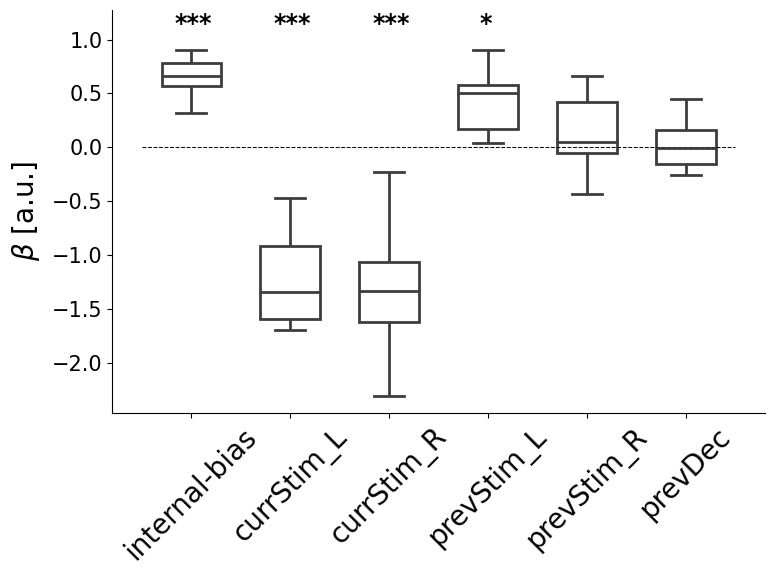

In [25]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(data=moutf_res_H_params_pri, showfliers=False, gap=.25, color='white', linewidth=2)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line
#plt.title('TF: Hold-still _ per Mouse', fontweight='bold')

plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize=20)
plt.ylabel(r'$\beta$ [a.u.]', fontsize=20, labelpad=7)

x = boxplot.get_xticks()
y = boxplot.get_ylim()
for i in x:
    if p_value_tf_H_pri[i]<0.001:
        plt.text(i-0.17, max(y)+0.015, '***', fontsize=17, fontweight='bold')
    elif p_value_tf_H_pri[i]<0.01:
        plt.text(i-0.13, max(y)+0.015, '**', fontsize=17, fontweight='bold')
    elif p_value_tf_H_pri[i]<0.05:
        plt.text(i-0.09, max(y)+0.015, '*', fontsize=17, fontweight='bold')

plt.ylim([y[0], y[1]+y[1]*0.2])

(-2.9044267892837525, 3.2831843090057373)

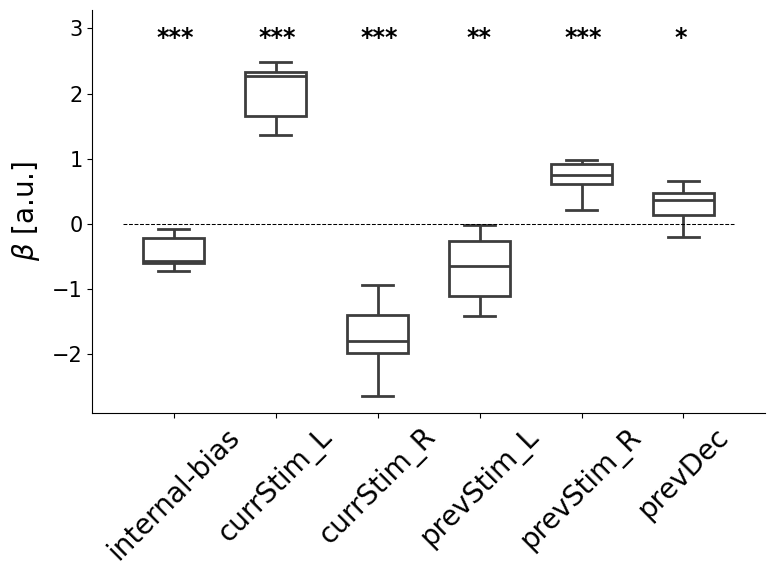

In [26]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(data=moutf_res_R_params_pri, showfliers=False, gap=.25, color='white', linewidth=2)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line
#plt.title('TF: Turn-right _ per Mouse', fontweight='bold')

plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize=20)
plt.ylabel(r'$\beta$ [a.u.]', fontsize=20, labelpad=7)

x = boxplot.get_xticks()
y = boxplot.get_ylim()
for i in x:
    if p_value_tf_R_pri[i]<0.001:
        plt.text(i-0.17, max(y)+0.015, '***', fontsize=17, fontweight='bold')
    elif p_value_tf_R_pri[i]<0.01:
        plt.text(i-0.13, max(y)+0.015, '**', fontsize=17, fontweight='bold')
    elif p_value_tf_R_pri[i]<0.05:
        plt.text(i-0.09, max(y)+0.015, '*', fontsize=17, fontweight='bold')

plt.ylim([y[0], y[1]+y[1]*0.2])

##### Transformed model

In [27]:
pred_reg_transf = list()
class_pred_reg_transf = list()
mou_weights_reg_transf = list()
mou_accuracy_reg_transf = list()
aic_transf = []
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevC_L[mou],mou_prevC_R[mou],mou_prevRw[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    mou_accuracy_reg_transf.append(history.history['accuracy'][-1]) # Retrieve the accuracy values from the history and pick the latest one
    pred_reg_transf.append(model.predict(X)) # Make predictions
    class_pred_reg_transf.append(np.argmax(pred_reg_transf[-1], axis=1)) # Convert softmax output to class predictions

    # calc AIC for model comparison
    likelihood = -history.history['loss'][-1]
    num_parameters = np.sum([np.prod(variable.shape) for variable in model.trainable_variables])
    aic_transf.append(-2 * likelihood + num_parameters * 2)
    print(f'AIC: {aic_transf[-1]}')

    # Access and print the weights of each layer
    for layer in model.layers:
        mou_weights_reg_transf.append(layer.get_weights())
        for i, weights in enumerate(layer.get_weights()):
            print(f"Weights {i + 1} shape:", weights.shape)
            print(weights)


**  Cori :
22/22 [==============================] - 0s 960us/step
AIC: 37.65559494495392
Weights 1 shape: (5, 3)
[[-1.5061227   2.2355573  -1.199591  ]
 [-0.53929496 -0.8846248   1.7339901 ]
 [ 0.53045046  0.31915867  0.55287343]
 [ 0.05017606  0.06610852 -0.8691658 ]
 [-0.8340463   0.17920254  0.4749017 ]]
Weights 2 shape: (3,)
[ 1.1975163  -0.66662925 -0.32602775]

**  Forssmann :
33/33 [==============================] - 0s 662us/step
AIC: 37.5076562166214
Weights 1 shape: (5, 3)
[[-1.0903732   1.9448712  -1.7293811 ]
 [-1.1790959  -1.8330353   2.6013846 ]
 [ 0.15029807 -0.08404446 -0.12348626]
 [ 0.07028345  0.26143077  0.23838998]
 [-0.8655318   0.24354725  1.049352  ]]
Weights 2 shape: (3,)
[ 1.5690843  -0.59641623 -0.8236539 ]

**  Hench :
44/44 [==============================] - 0s 361us/step
AIC: 37.440678119659424
Weights 1 shape: (5, 3)
[[-1.2895899   1.924096   -2.296859  ]
 [-1.3400224  -1.7170492   2.0282614 ]
 [ 0.7330559  -0.15427183  1.1969028 ]
 [-0.48355067 -0.337383

In [28]:
# @title Ordering estimations
moutf_res_L_params_transf = np.array([])
moutf_res_H_params_transf = np.array([])
moutf_res_R_params_transf = np.array([])
for mou in range(len(unique_name)):
    temp_L_params=list()
    temp_L_params.append(mou_weights_reg_transf[mou][1][2]) 
    # '[1]' marks the internal-bias weights, '[2]' marks the left-turn dec
    temp_H_params=list()
    temp_H_params.append(mou_weights_reg_transf[mou][1][0]) 
    # '[1]' marks the internal-bias weights, '[0]' marks the hold-still dec
    temp_R_params=list()
    temp_R_params.append(mou_weights_reg_transf[mou][1][1]) 
    # 1st '[1]' marks the internal-bias weights, 2nd '[1]' marks the right-turn dec
    for param in range(input_num): # b0 are in below; other parameters are in above
        temp_L_params.append(mou_weights_reg_transf[mou][0][param][2]) 
        # '[0]' marks the experiment-related weights, '[2]' marks the left-turn dec
        temp_H_params.append(mou_weights_reg_transf[mou][0][param][0]) 
        # 1st '[0]' marks the experiment-related weights, 2nd '[0]' marks the hold-still dec
        temp_R_params.append(mou_weights_reg_transf[mou][0][param][1]) 
        # '[0]' marks the experiment-related weights, '[1]' marks the right-turn dec
    temptemp_L_params = np.array(temp_L_params).reshape(1,len(temp_L_params))
    temptemp_H_params = np.array(temp_H_params).reshape(1,len(temp_H_params))
    temptemp_R_params = np.array(temp_R_params).reshape(1,len(temp_R_params))
    if mou:
        moutf_res_L_params_transf = np.vstack((moutf_res_L_params_transf, temptemp_L_params))
        moutf_res_H_params_transf = np.vstack((moutf_res_H_params_transf, temptemp_H_params))
        moutf_res_R_params_transf = np.vstack((moutf_res_R_params_transf, temptemp_R_params))
    else:
        moutf_res_L_params_transf = temptemp_L_params
        moutf_res_H_params_transf = temptemp_H_params
        moutf_res_R_params_transf = temptemp_R_params


In [29]:
# @title Statistics
tstat_tf_L_transf = [list(), list(), list(), list(), list(), list()]
p_value_tf_L_transf = [list(), list(), list(), list(), list(), list()]
tstat_tf_H_transf = [list(), list(), list(), list(), list(), list()]
p_value_tf_H_transf = [list(), list(), list(), list(), list(), list()]
tstat_tf_R_transf = [list(), list(), list(), list(), list(), list()]
p_value_tf_R_transf = [list(), list(), list(), list(), list(), list()]
feature_names=['internal-bias','currStim_L','currStim_R','prevStim_L','prevStim_R', 'prevRw']
for param in range(np.size(moutf_res_L_params_transf, axis=1)):
    # the last parameter from Theiler is an outlier, thus is removed below
    tstat_tf_L_transf[param], p_value_tf_L_transf[param] = stats.ttest_1samp(moutf_res_L_params_transf[:,param], popmean=0)
    tstat_tf_H_transf[param], p_value_tf_H_transf[param] = stats.ttest_1samp(moutf_res_H_params_transf[:,param], popmean=0)
    tstat_tf_R_transf[param], p_value_tf_R_transf[param] = stats.ttest_1samp(moutf_res_R_params_transf[:,param], popmean=0)
    print('\nparam: ', feature_names[param])
    print('t-statistic: turn-left, %.1f; hold-still, %.1f; turn-right, %.1f'
          %(tstat_tf_L_transf[param],tstat_tf_H_transf[param],tstat_tf_R_transf[param]))
    print('p-value: turn-left, %.3f; hold-still, %.3f; turn-right, %.3f'
          %(p_value_tf_L_transf[param],p_value_tf_H_transf[param],p_value_tf_R_transf[param]))


param:  internal-bias
t-statistic: turn-left, -4.2; hold-still, 17.1; turn-right, -8.1
p-value: turn-left, 0.002; hold-still, 0.000; turn-right, 0.000

param:  currStim_L
t-statistic: turn-left, -8.5; hold-still, -6.1; turn-right, 15.9
p-value: turn-left, 0.000; hold-still, 0.000; turn-right, 0.000

param:  currStim_R
t-statistic: turn-left, 21.8; hold-still, -9.9; turn-right, -13.6
p-value: turn-left, 0.000; hold-still, 0.000; turn-right, 0.000

param:  prevStim_L
t-statistic: turn-left, 2.9; hold-still, 3.8; turn-right, -3.3
p-value: turn-left, 0.017; hold-still, 0.004; turn-right, 0.009

param:  prevStim_R
t-statistic: turn-left, -1.7; hold-still, -0.2; turn-right, 1.2
p-value: turn-left, 0.114; hold-still, 0.856; turn-right, 0.251

param:  prevRw
t-statistic: turn-left, 4.2; hold-still, -7.5; turn-right, 5.9
p-value: turn-left, 0.002; hold-still, 0.000; turn-right, 0.000


(-3.2724586606025694, 3.4573097562789914)

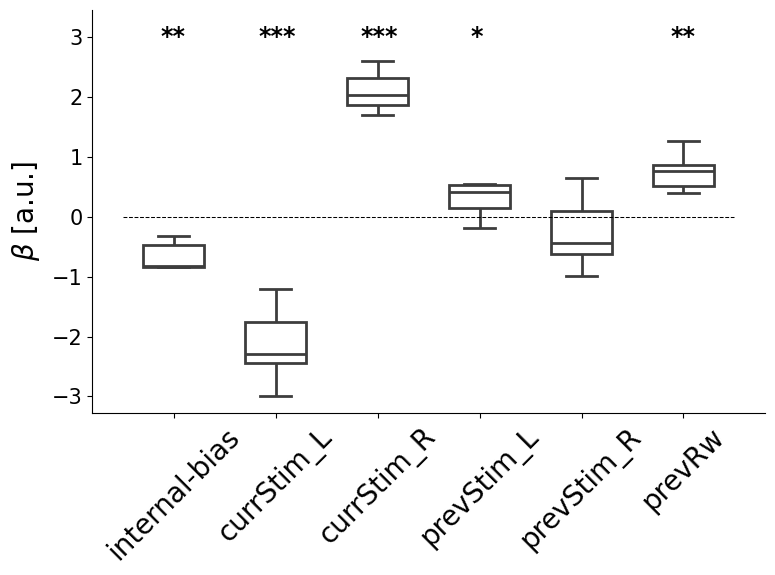

In [30]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(data=moutf_res_L_params_transf, showfliers=False, gap=.25, color='white', linewidth=2)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line
#plt.title('TF: Turn-left _ per Mouse', fontweight='bold')

plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize=20)
plt.ylabel(r'$\beta$ [a.u.]', fontsize=20, labelpad=7)

x = boxplot.get_xticks()
y = boxplot.get_ylim()
for i in x:
    if p_value_tf_L_transf[i]<0.001:
        plt.text(i-0.17, max(y)+0.015, '***', fontsize=17, fontweight='bold')
    elif p_value_tf_L_transf[i]<0.01:
        plt.text(i-0.13, max(y)+0.015, '**', fontsize=17, fontweight='bold')
    elif p_value_tf_L_transf[i]<0.05:
        plt.text(i-0.09, max(y)+0.015, '*', fontsize=17, fontweight='bold')

plt.ylim([y[0], y[1]+y[1]*0.2])

(-2.1502550184726714, 2.5394544768333436)

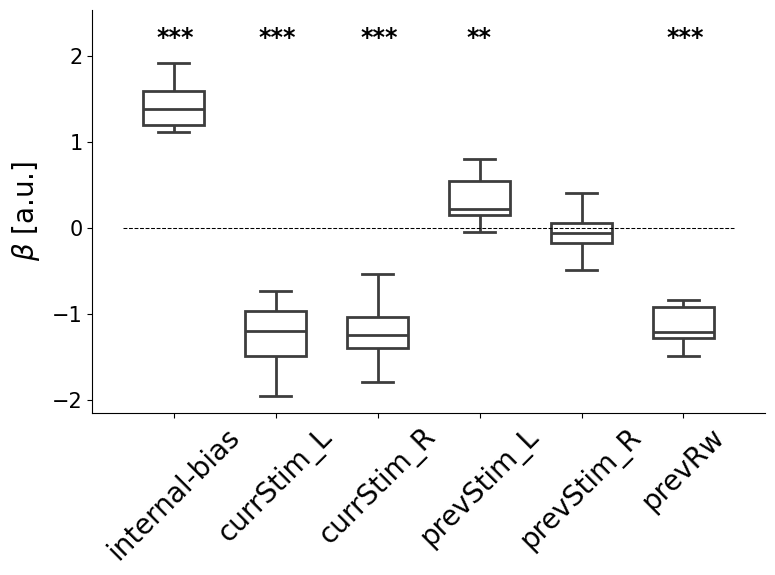

In [31]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(data=moutf_res_H_params_transf, showfliers=False, gap=.25, color='white', linewidth=2)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line
#plt.title('TF: Hold-still _ per Mouse', fontweight='bold')

plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize=20)
plt.ylabel(r'$\beta$ [a.u.]', fontsize=20, labelpad=7)

x = boxplot.get_xticks()
y = boxplot.get_ylim()
for i in x:
    if p_value_tf_H_transf[i]<0.001:
        plt.text(i-0.17, max(y)+0.015, '***', fontsize=17, fontweight='bold')
    elif p_value_tf_H_transf[i]<0.01:
        plt.text(i-0.13, max(y)+0.015, '**', fontsize=17, fontweight='bold')
    elif p_value_tf_H_transf[i]<0.05:
        plt.text(i-0.09, max(y)+0.015, '*', fontsize=17, fontweight='bold')

plt.ylim([y[0], y[1]+y[1]*0.2])

(-2.420169174671173, 3.545718455314636)

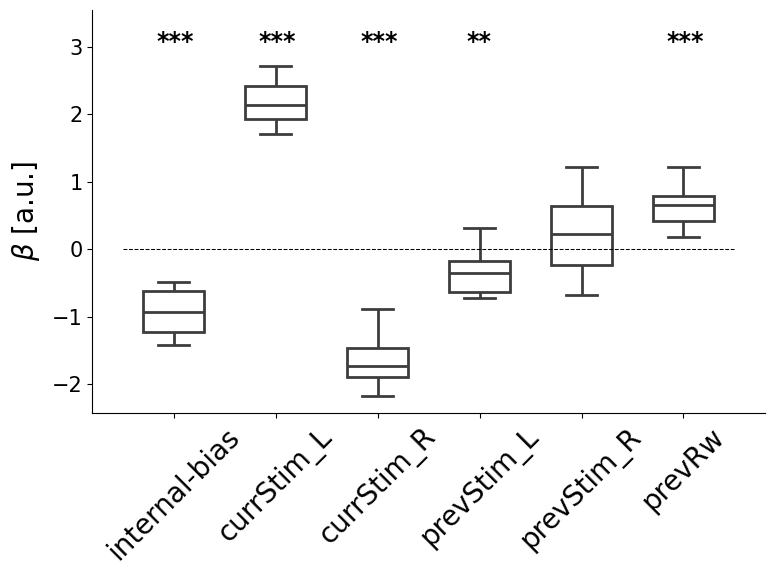

In [32]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(data=moutf_res_R_params_transf, showfliers=False, gap=.25, color='white', linewidth=2)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line
#plt.title('TF: Turn-right _ per Mouse', fontweight='bold')

plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize=20)
plt.ylabel(r'$\beta$ [a.u.]', fontsize=20, labelpad=7)

x = boxplot.get_xticks()
y = boxplot.get_ylim()
for i in x:
    if p_value_tf_R_transf[i]<0.001:
        plt.text(i-0.17, max(y)+0.015, '***', fontsize=17, fontweight='bold')
    elif p_value_tf_R_transf[i]<0.01:
        plt.text(i-0.13, max(y)+0.015, '**', fontsize=17, fontweight='bold')
    elif p_value_tf_R_transf[i]<0.05:
        plt.text(i-0.09, max(y)+0.015, '*', fontsize=17, fontweight='bold')

plt.ylim([y[0], y[1]+y[1]*0.2])

### Alternative Models

#### 1. no-history: beta0 + currStim

In [33]:
aic_altm1 = []
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    likelihood = -history.history['loss'][-1]
    num_parameters = np.sum([np.prod(variable.shape) for variable in model.trainable_variables])
    aic_altm1.append(-2 * likelihood + num_parameters * 2)
    print(f'AIC: {aic_altm1[-1]}')


**  Cori :
AIC: 19.757335662841797

**  Forssmann :
AIC: 19.610584259033203

**  Hench :
AIC: 19.638861656188965

**  Lederberg :
AIC: 19.416267156600952

**  Moniz :
AIC: 19.76989507675171

**  Muller :
AIC: 19.64832878112793

**  Radnitz :
AIC: 19.616429209709167

**  Richards :
AIC: 19.6778507232666

**  Tatum :
AIC: 19.483375906944275

**  Theiler :
AIC: 19.489017367362976


#### 2. stim-history: beta0 + currStim + prevStim

In [34]:
aic_altm2 = []
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevC_L[mou],mou_prevC_R[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    likelihood = -history.history['loss'][-1]
    num_parameters = np.sum([np.prod(variable.shape) for variable in model.trainable_variables])
    aic_altm2.append(-2 * likelihood + num_parameters * 2)
    print(f'AIC: {aic_altm2[-1]}')



**  Cori :
AIC: 31.718382358551025

**  Forssmann :
AIC: 31.604996919631958

**  Hench :
AIC: 31.594114422798157

**  Lederberg :
AIC: 31.409291982650757

**  Moniz :
AIC: 31.72049379348755

**  Muller :
AIC: 31.628113389015198

**  Radnitz :
AIC: 31.580930709838867

**  Richards :
AIC: 31.61870551109314

**  Tatum :
AIC: 31.440951347351074

**  Theiler :
AIC: 31.452685475349426


#### 3. dec-history: beta0 + currStim + prevDec

In [35]:
aic_altm3 = []
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevD[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    likelihood = -history.history['loss'][-1]
    num_parameters = np.sum([np.prod(variable.shape) for variable in model.trainable_variables])
    aic_altm3.append(-2 * likelihood + num_parameters * 2)
    print(f'AIC: {aic_altm3[-1]}')



**  Cori :
AIC: 25.752532482147217

**  Forssmann :
AIC: 25.61029815673828

**  Hench :
AIC: 25.636051058769226

**  Lederberg :
AIC: 25.41316294670105

**  Moniz :
AIC: 25.75668430328369

**  Muller :
AIC: 25.633396863937378

**  Radnitz :
AIC: 25.6107120513916

**  Richards :
AIC: 25.676309823989868

**  Tatum :
AIC: 25.474887371063232

**  Theiler :
AIC: 25.48842990398407


#### 4. reward-history: beta0 + currStim + prevRw

In [36]:
aic_altm4 = []
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevRw[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    likelihood = -history.history['loss'][-1]
    num_parameters = np.sum([np.prod(variable.shape) for variable in model.trainable_variables])
    aic_altm4.append(-2 * likelihood + num_parameters * 2)
    print(f'AIC: {aic_altm4[-1]}')



**  Cori :
AIC: 25.67725384235382

**  Forssmann :
AIC: 25.509228706359863

**  Hench :
AIC: 25.47070050239563

**  Lederberg :
AIC: 25.274975657463074

**  Moniz :
AIC: 25.700029730796814

**  Muller :
AIC: 25.52536714076996

**  Radnitz :
AIC: 25.409948587417603

**  Richards :
AIC: 25.412372708320618

**  Tatum :
AIC: 25.358272075653076

**  Theiler :
AIC: 25.361069560050964
